In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
import os
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
from pathlib import Path

# Architecture for ACModel, Rollouts, and PPO

In [4]:
t = torch.tensor([[1, 2, 3], [4, 5, 6]])

In [6]:
# these following functions were coded with reference to
# https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail

def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def init_gru_params(gru):
    for name, param in gru.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0)
        elif 'weight' in name:
            nn.init.orthogonal_(param)

# this is from https://github.com/p-morais/deep-rl/blob/master/rl/distributions/gaussian.py
class DiagonalGaussian(nn.Module):
    def __init__(self, num_outputs, init_std=1, learn_std=True):
        super(DiagonalGaussian, self).__init__()

        self.logstd = nn.Parameter(
            torch.ones(1, num_outputs) * np.log(init_std),
            requires_grad=learn_std
        )

        self.learn_std = learn_std

    def forward(self, x):
        mean = x
        
#         print(self.logstd.sum())
        std = self.logstd.exp()
        
        return mean, std

    def sample(self, x, deterministic):
        if deterministic is False:
            action = self.evaluate(x).sample()
        else:
            action, _ = self(x)

        return action

    def evaluate(self, x):
        mean, std = self(x)
        output = torch.distributions.Normal(mean, std)
        return output

    
class ACModel(nn.Module):
    def __init__(self, num_tickers, time_horizon, num_ta_indicators, recurrent, num_layers=1, hidden_size=64, learn_std=True):
        super().__init__()
        
        # num tickers, time horizon, and num ta used to compute the number of inputs
        # for recurrent network, the input size to GRU is just the num tickers (prices at each timestep)
        # and input size to the actor/critic is the current cash, holdings, and technical analysis for each ticker
        # for feedforward, the input size is num tickers * time horizon
        # and input size to the actor/critic is the current cash, holdings, and technical analysis for each ticker
        self.num_tickers = num_tickers
        self.time_horizon = time_horizon
        self.num_ta_indicators = num_ta_indicators
        
        # TODO changed for cartpole
        # action_dim = num_tickers + 1 # buy/sell for each ticker + 1 for cash
        action_dim = 6
        self.action_dim = action_dim
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.recurrent = recurrent
        if self.recurrent:
            num_inputs = num_tickers
            
            self.gru_actor = nn.GRU(num_inputs, hidden_size, num_layers=num_layers, batch_first=True)
            self.gru_critic = nn.GRU(num_inputs, hidden_size, num_layers=num_layers, batch_first=True)
            
            init_gru_params(self.gru_actor)
            init_gru_params(self.gru_critic)
        else:
            num_inputs = num_tickers * time_horizon
            
            seq = [nn.Linear(num_inputs, hidden_size), nn.Tanh()]
            for i in range(num_layers-1):
                seq.extend([nn.Linear(hidden_size, hidden_size), nn.Tanh()])
            
            self.fwd_actor = nn.Sequential(*seq)
            self.fwd_critic = nn.Sequential(*seq)
        
        # output of gru/fwd, cash, holdings, and then all the ta indicators
        # TODO changed for cartpole
        # num_inputs = hidden_size + 1 + num_tickers + num_tickers * num_ta_indicators
        num_inputs = hidden_size
        
        mid_layer = int(hidden_size/2)
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, mid_layer), nn.Tanh(),
            nn.Linear(mid_layer, action_dim), nn.Tanh(),
        )
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, mid_layer), nn.Tanh(),
            nn.Linear(mid_layer, 1)
        )
        
        self.dist = DiagonalGaussian(action_dim, learn_std=learn_std)

        self.apply(init_params)
    
    def init_hidden(self, batch_size):
        # h0 should be of shape (num_layers * num_directions, batch size, hidden_size)
        # num_layers is 1, and RNN is not bidirectional, so num_dir = 1
        # (1, batch_size, hidden size)
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return nn.Parameter(h, requires_grad=True)

    def forward(self, obs, rnn_h_a=None, rnn_h_c=None):
        # suppose obs is just a vector of previous prices
        
        price_obs_in = obs[:,:self.num_tickers * self.time_horizon]
        other_obs = obs[:,self.num_tickers * self.time_horizon:]
        
        price_obs = torch.zeros(price_obs_in.shape)
        
        price_obs[:,0] = price_obs_in[:,0]
        price_obs[:,1:] = torch.sin(price_obs_in[:,1:])

        if self.recurrent:
            if rnn_h_a is None:
                rnn_h_a = self.init_hidden(obs.size(0))
            if rnn_h_c is None:
                rnn_h_c = self.init_hidden(obs.size(0))
            
            obs = torch.reshape(price_obs, (-1, self.time_horizon, self.num_tickers))
            obs_actor, rnn_h_a = self.gru_actor(obs, rnn_h_a)

            obs_actor = obs_actor[:,-1,:] # selecting the last element
            
            obs_critic, rnn_h_c = self.gru_critic(obs, rnn_h_c)
            obs_critic = obs_critic[:,-1,:] # selecting the last element
        else:
            obs_actor = self.fwd_actor(price_obs)
            obs_critic = self.fwd_critic(price_obs)
            
#         obs_actor = torch.cat((obs_actor, other_obs), 1)
#         obs_critic = torch.cat((obs_critic, other_obs), 1)
        
        forward_actor = self.actor(obs_actor)
        action_dist = self.dist.evaluate(forward_actor)
        
        forward_critic = self.critic(obs_critic)
        
        return action_dist, forward_critic, rnn_h_a, rnn_h_c

In [7]:
class RolloutBuffer:
    def __init__(self, acmodel, env, discount=0.99, gae_lambda=0.95, device=None):
        # TODO changed for cartpole
        # self.episode_length = env.episode_length
        self.episode_length = 300 - 1
        self.device = device
        self.acmodel = acmodel
        self.discount = discount
        self.gae_lambda = gae_lambda
        
        self.actions = None
        self.values = None
        self.rewards = None
        self.log_probs = None
        self.obss = None
        self.gaes = None
        self.returns = None
        
        self.action_space_dim = env.action_space.shape[0]
        
        self.num_rollouts = 3
        self.reset()
        
        
    def reset(self):
        self.actions = torch.zeros((self.num_rollouts*self.episode_length, self.action_space_dim), device=self.device)
        self.values = torch.zeros(self.num_rollouts*self.episode_length, device=self.device)
        self.rewards = torch.zeros(self.num_rollouts*self.episode_length, device=self.device)
        self.returns = torch.zeros(self.num_rollouts*self.episode_length, device=self.device)
        
        self.log_probs = torch.zeros((self.num_rollouts*self.episode_length, self.action_space_dim), device=self.device)
        self.obss = [None] * (self.episode_length*self.num_rollouts)
        
        self.gaes = torch.zeros(self.num_rollouts*self.episode_length, device=self.device)
        
    
    def process_obs(self, obs):
        # TODO: formatting stuff
        if isinstance(obs, list):
            obs = np.stack(obs)

        if len(obs.shape) == 1: # 1 dimensional
            obs = np.expand_dims(obs, axis=0)
            
        return torch.FloatTensor(obs)
    
    def collect_experience(self):
        
        total_return = 0
        self.returns = []
        
        for ep in range(self.num_rollouts):
            obs = env.reset()
            
            self.actions_ = torch.zeros((self.episode_length, self.action_space_dim), device=self.device)
            self.values_ = torch.zeros(self.episode_length, device=self.device)
            self.rewards_ = torch.zeros(self.episode_length, device=self.device)
            self.obss_ = [None] * (self.episode_length)
            self.log_probs_ = torch.zeros((self.episode_length, self.action_space_dim), device=self.device)
            
            
            
            T = 0
        
            while True:
                with torch.no_grad():
                    dist, value, _, _ = self.acmodel(self.process_obs(obs))

                action = dist.sample()

                self.obss_[T] = obs

                obs, reward, done, _ = env.step(action)

                total_return += reward

                self.actions_[T] = action
                self.values_[T] = value
                self.rewards_[T] = float(reward)
                self.log_probs_[T] = dist.log_prob(action)


                T += 1
                if done:
                    break
                    
            self.actions[ep*self.episode_length:(ep+1)*self.episode_length] = self.actions_[:T]
            self.values[ep*self.episode_length:(ep+1)*self.episode_length] = self.values_[:T]
            self.rewards[ep*self.episode_length:(ep+1)*self.episode_length] = self.rewards_[:T]
            
            
            discounted_reward = 0.0
            self.returns_ = []
            for r in reversed(self.rewards_):
                discounted_reward = r + self.discount*discounted_reward
                self.returns_.insert(0, discounted_reward)
            self.returns[ep*self.episode_length:(ep+1)*self.episode_length] = self.returns_[:T]
            

            self.log_probs[ep*self.episode_length:(ep+1)*self.episode_length] = self.log_probs_[:T]
            
            self.obss[ep*self.episode_length:(ep+1)*self.episode_length] = self.process_obs(self.obss_[:T])
            self.gaes_ = self.compute_advantage_gae(self.rewards_, self.values_, T)
            self.gaes[ep*self.episode_length:(ep+1)*self.episode_length] = self.gaes_[:T]
            
        
        self.obss = torch.FloatTensor(np.stack(self.obss))
        self.returns = torch.FloatTensor(self.returns)
        
        #self.gaes = (self.gaes - self.gaes.mean())/(self.gaes.std() + 1e-8)
        
        return total_return/self.num_rollouts, T
            
    def compute_advantage_gae(self, rewards, values, T):

        deltas = torch.cat((rewards[:-1] + self.discount*values[1:] - values[:-1], rewards[-1:] - values[-1:]))
        deltas_flip = torch.flip(deltas, [0])
        A = 0.0*deltas_flip[0]
        advantages = torch.zeros_like(values)
        for i in range(len(deltas_flip)):
            A = self.discount*self.gae_lambda*A + deltas_flip[i]
            advantages[i] = A
        advantages = torch.flip(advantages, [0])
        return advantages
            
            
            
        coeffs = torch.pow(self.discount*self.gae_lambda, torch.arange(len(deltas)))
        return torch.cumsum(torch.multiply(deltas, coeffs), -1)
    
    
        

In [8]:
class PPO:
    def __init__(self,
                 acmodel,
                 clip_ratio=0.2,
                 entropy_coef=0.01,
                 lr=2e-4,
                 target_kl=0.01,
                 train_iters=10):
        
        self.acmodel = acmodel
        self.clip_ratio = clip_ratio
        self.entropy_coef = entropy_coef
        self.target_kl=target_kl
        self.train_iters = train_iters
        
        self.optimizer = torch.optim.Adam(acmodel.parameters(), lr=lr)
        
    def update(self, rollouts):
        # rollouts should be RolloutBuffer object

        dist, _, _, _ = self.acmodel(rollouts.obss) # TODO may need to process these observations
        old_logp = dist.log_prob(rollouts.actions.view(-1,self.acmodel.action_dim)).detach()
        

#         policy_loss, _ = self._compute_policy_loss_ppo(rollouts.obss, old_logp, rollouts.actions, rollouts.gaes)
#         value_loss = self._compute_value_loss(rollouts.obss, rollouts.returns)
        
        batch_size = 64
        avg_policy_loss, avg_value_loss = 0, 0
        for i in range(self.train_iters):
            rand_idxs = np.random.choice(np.arange(len(rollouts.obss)), batch_size , replace = False)
            
            self.optimizer.zero_grad()
            pi_loss, approx_kl = self._compute_policy_loss_ppo(rollouts.obss[rand_idxs], old_logp[rand_idxs], 
                                                               rollouts.actions[rand_idxs], rollouts.gaes[rand_idxs])

            v_loss = self._compute_value_loss(rollouts.obss[rand_idxs], rollouts.returns[rand_idxs])
            #print ('vloss:', v_loss, 'pi_loss:', pi_loss)
            loss = .5*v_loss + pi_loss
            
            avg_policy_loss += pi_loss.item()
            avg_value_loss += v_loss.item()
   
            
            if approx_kl > 1.5 * self.target_kl:
                break
            
            loss.backward(retain_graph=True) # lol todo are we supposed to retain graph?
            #loss.backward()
            
#             torch.nn.utils.clip_grad_norm_(acmodel.parameters(), .5)
            
            self.optimizer.step()
            
        return avg_policy_loss/self.train_iters, avg_value_loss/self.train_iters
        
    def _compute_policy_loss_ppo(self, obs, old_logp, actions, advantages):
        policy_loss, approx_kl = 0, 0
        

        dist, _, _, _ = self.acmodel(obs)
        
        new_logp = dist.log_prob(actions.view(-1,self.acmodel.action_dim))
        
        entropy = torch.mean(dist.entropy())
        entropy = entropy * self.entropy_coef

        r = torch.exp(new_logp - old_logp.detach())

        clamp_adv = torch.clamp(r, 1-self.clip_ratio, 1+self.clip_ratio)*advantages.view(-1,1)
        
        min_advs = torch.minimum(r*advantages.view(-1,1), clamp_adv)
        

        policy_loss = -torch.mean(min_advs) - entropy
        approx_kl = (old_logp - new_logp).mean()
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(self, obs, returns):
        _, values, _, _ = self.acmodel(obs)

        value_loss = torch.mean((returns.view(-1,1) - values.view(-1,1))**2)

        return value_loss



# Half Cheetah Gym Attempt

In [9]:
import gym
from gym.envs.registration import registry, register

In [10]:
import numpy as np
from gym import utils
from gym.envs.mujoco import mujoco_env

class HalfCheetahEnv(mujoco_env.MujocoEnv, utils.EzPickle):
    prev_obs = [np.zeros((8,)), np.zeros((8,)), np.zeros((8,))]
    timesteps = 0
    timestep_limit = 300
    time_horizon = 3
    
    def __init__(self):
        mujoco_env.MujocoEnv.__init__(self, 'half_cheetah.xml', 5)
        utils.EzPickle.__init__(self)
#         self.prev_obs = [np.zeros((8,)), np.zeros((8,)), np.zeros((8,))]

    def step(self, action):
        xposbefore = self.sim.data.qpos[0]
        self.do_simulation(action, self.frame_skip)
        xposafter = self.sim.data.qpos[0]
        ob = self._get_obs()
        reward_ctrl = - 0.1 * np.square(action).sum()
        reward_run = (xposafter - xposbefore)/self.dt
        reward = reward_ctrl + reward_run
        done = self.is_done()
        self.timesteps += 1
        return ob, reward, done, dict(reward_run=reward_run, reward_ctrl=reward_ctrl)
    
    def is_done(self):
        # Kill trial when too much time has passed
        if self.timesteps >= self.timestep_limit:
            return True
                
        return False

    def _shift_prev_obs(self, new_qpos):
        for i in range(self.time_horizon-1):
            self.prev_obs[i] = self.prev_obs[i+1]
        self.prev_obs[self.time_horizon-1] = new_qpos
        
    def _get_obs(self):
        self._shift_prev_obs(self.sim.data.qpos.flat[1:])
        return np.concatenate(self.prev_obs)

    def reset_model(self):
        qpos = self.init_qpos + self.np_random.uniform(low=-.1, high=.1, size=self.model.nq)
        qvel = self.init_qvel + self.np_random.randn(self.model.nv) * .1
        self.prev_obs = [np.zeros((8,)), np.zeros((8,)), np.zeros((8,))]
        self.timesteps = 0
        self.set_state(qpos, qvel)
        
        for t in range(self.time_horizon-1):
            # start with a few random actions to initialize
            action = np.zeros((6,))
            self.step(action)
        
        return self._get_obs()

    def viewer_setup(self):
        self.viewer.cam.distance = self.model.stat.extent * 0.5

In [11]:
env_name = 'HalfCheetahWithMemory-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:HalfCheetahEnv',
)
env = gym.make('HalfCheetahWithMemory-v0')

In [12]:
env.reset()

array([ 0.00280302, -0.0177953 ,  0.01759858,  0.0142407 , -0.01749979,
        0.02136942, -0.01226771, -0.03662504, -0.04642554, -0.01566588,
       -0.00827533, -0.01291829,  0.02598548, -0.01750105,  0.0160785 ,
        0.01706519, -0.04642554, -0.01566588, -0.00827533, -0.01291829,
        0.02598548, -0.01750105,  0.0160785 ,  0.01706519])

In [13]:
env.reset().shape

(24,)

In [14]:
torch.tensor(1).item()

1

In [15]:
# recurrent model
acmodel = ACModel(num_tickers=8, time_horizon=3, num_ta_indicators=0, recurrent=False, hidden_size=32, num_layers=2)
rollouts = RolloutBuffer(acmodel, env)
rollouts.collect_experience()
ppo = PPO(acmodel)
ppo.update(rollouts)

(10.349458408355712, 2161.0042114257812)

In [16]:
# feedforward model
acmodel = ACModel(num_tickers=8, time_horizon=3, num_ta_indicators=0, recurrent=False, hidden_size=32, num_layers=2)
rollouts = RolloutBuffer(acmodel, env)
rollouts.collect_experience()
ppo = PPO(acmodel)
ppo.update(rollouts)

(11.307026863098145, 3180.6031982421873)

In [17]:
rollouts.obss.shape

torch.Size([897, 24])

Ok so looks like the Cartpole gym syntactically works.. Let's try to train

# Run experiment on Cartpole

In [19]:
# Adapted from 6.884 HW4

def run_experiment(acmodel, ppo_kwargs, rollout_kwargs = {}, max_episodes=200000, score_threshold=0.8, iteration=0):
    # acmodel_args should be dictionary corresponding to inputs of acmodel
    # ie {num_tickers: 4, time_horizon: 5, etc..}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make('HalfCheetahWithMemory-v0')
    
    acmodel.to(device)

    is_solved = False
    
    SMOOTH_REWARD_WINDOW = 30

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW
    
    num_frames = 0
    rollouts = RolloutBuffer(acmodel, env, **rollout_kwargs)
    ppo = PPO(acmodel, **ppo_kwargs)
    
    lr = ppo_kwargs['lr']
    checkpoint_path = f'./checkpoints/6actions_sin_cheetah{iteration}/acmodel_rnn{acmodel.recurrent}_{acmodel.num_layers}lay_{acmodel.hidden_size}hid_{lr}lr'

    pbar = tqdm(range(max_episodes))
    for update in pbar:
        rollouts.reset() # resetting the buffer
        total_return, T = rollouts.collect_experience()
        total_return = total_return.item()
        policy_loss, value_loss = ppo.update(rollouts)
        
        num_frames += T
        rewards.append(total_return)
        
        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':total_return, 'policy_loss': policy_loss, 'value_loss': value_loss}

        pd_logs.append(data)

        pbar.set_postfix(data)

        # save results every 500
        if update % 500 == 0:
            Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
            torch.save(acmodel.state_dict(), f'{checkpoint_path}/{update}')

        # Early terminate
        if smooth_reward >= score_threshold:
            is_solved = True
            Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
            torch.save(acmodel.state_dict(), f'{checkpoint_path}/solved')
            break

    if is_solved:
        print('Solved!')
    else:
        print('Unsolved. Check your implementation.')
        
    logs = pd.DataFrame(pd_logs).set_index('episode')

    logs.to_pickle(f'{checkpoint_path}/logs')
    
    return pd.DataFrame(pd_logs).set_index('episode')

In [20]:
layers = 1

100%|██████████| 5000/5000 [1:08:28<00:00,  1.22it/s, episode=4999, num_frames=1.5e+6, smooth_reward=567, reward=629, policy_loss=-8.2, value_loss=4.79e+3]     


Unsolved. Check your implementation.
Num eps:  5000


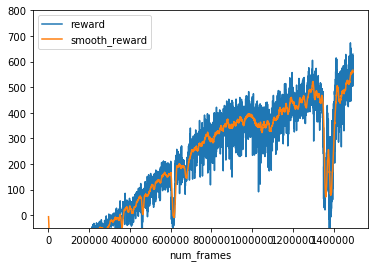

100%|██████████| 5000/5000 [1:06:37<00:00,  1.25it/s, episode=4999, num_frames=1.5e+6, smooth_reward=233, reward=209, policy_loss=1.78, value_loss=398]        

Unsolved. Check your implementation.
Num eps:  5000


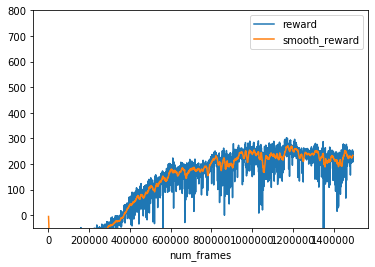

100%|██████████| 5000/5000 [1:06:31<00:00,  1.25it/s, episode=4999, num_frames=1.5e+6, smooth_reward=514, reward=544, policy_loss=-3.7, value_loss=2.95e+3]     

Unsolved. Check your implementation.
Num eps:  5000


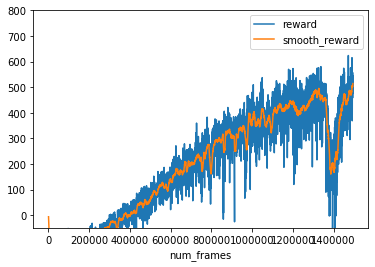

100%|██████████| 5000/5000 [1:06:29<00:00,  1.25it/s, episode=4999, num_frames=1.5e+6, smooth_reward=321, reward=385, policy_loss=-2.77, value_loss=1.33e+3]   

Unsolved. Check your implementation.
Num eps:  5000


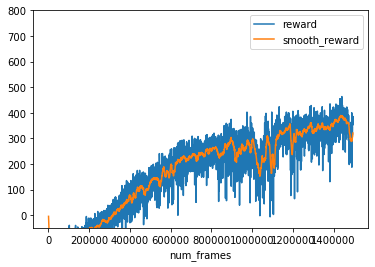

100%|██████████| 5000/5000 [1:06:21<00:00,  1.26it/s, episode=4999, num_frames=1.5e+6, smooth_reward=211, reward=222, policy_loss=-.356, value_loss=430]      


Unsolved. Check your implementation.
Num eps:  5000


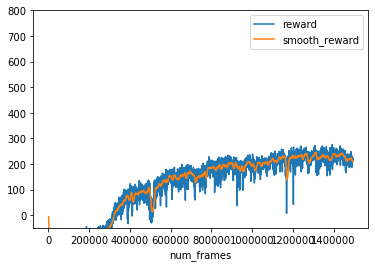

In [21]:
# feedforward
fwd = []
for i in range(5):
    acmodel_kwargs = {'num_tickers': 8, 'time_horizon': 3, 'num_ta_indicators': 0, 'recurrent': False, 'hidden_size': 32, 'num_layers': layers}
    acmodel = ACModel(**acmodel_kwargs)
    ppo_kwargs = {'lr': 5e-4, 'entropy_coef': 0.01, 'train_iters': 10}
    fwd_df = run_experiment(acmodel, ppo_kwargs, max_episodes=5000, score_threshold=2000)
    print("Num eps: ", len(fwd_df))
    ax=fwd_df.plot(x='num_frames', y=['reward', 'smooth_reward'])
    ax.set_ylim((-50, 800))
    plt.show()
    fwd.append(fwd_df)

100%|██████████| 5000/5000 [2:15:37<00:00,  1.63s/it, episode=4999, num_frames=1.5e+6, smooth_reward=805, reward=803, policy_loss=-2.39, value_loss=5.2e+3]     


Unsolved. Check your implementation.
Num eps:  5000


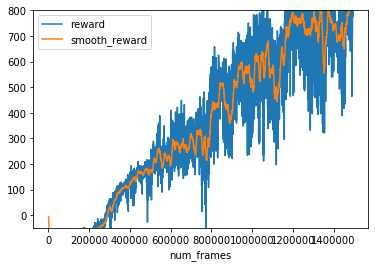

100%|██████████| 5000/5000 [2:23:15<00:00,  1.72s/it, episode=4999, num_frames=1.5e+6, smooth_reward=722, reward=801, policy_loss=-6.97, value_loss=6.48e+3]   


Unsolved. Check your implementation.
Num eps:  5000


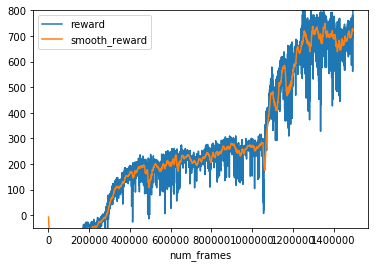

 22%|██▏       | 1086/5000 [35:35<2:57:30,  2.72s/it, episode=1085, num_frames=324714, smooth_reward=84, reward=52.2, policy_loss=1.44, value_loss=578]      

In [ ]:
# recurrent
rnn = []
for i in range(5):
    acmodel_kwargs = {'num_tickers': 8, 'time_horizon': 3, 'num_ta_indicators': 0, 'recurrent': True, 'hidden_size': 32, 'num_layers': layers}
    acmodel = ACModel(**acmodel_kwargs)
    ppo_kwargs = {'lr': 5e-4, 'entropy_coef': 0.01, 'train_iters': 10}
    rnn_df = run_experiment(acmodel, ppo_kwargs, max_episodes=5000, score_threshold=2000)
    print("Num eps: ", len(rnn_df))
    ax=rnn_df.plot(x='num_frames', y=['reward', 'smooth_reward'])
    ax.set_ylim((-50, 800))
    plt.show()
    rnn.append(rnn_df)

In [ ]:
import matplotlib.style as style
import seaborn as sns

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

for df in fwd:
    df['label'] = "Feedforward"
    
for df in rnn:
    df['label'] = "Recurrent"

all_logs = []
all_logs.extend(fwd)
all_logs.extend(rnn)

logs = pd.concat(all_logs, ignore_index=True)
nums = len(logs['label'].unique())
palette = sns.color_palette("hls", nums)
fig = plt.figure()
ax = sns.lineplot(x='num_frames', y='smooth_reward', data=logs, estimator='mean', palette=palette, hue='label')
ax.set_title('Comparing Smooth Reward')
ax.set_xlabel('Num Frames')
ax.set_ylabel('Smooth Reward')
ax.set_ylim((-50, 600))
plt.show()
fig.savefig('ppo - half cheetah - 2state(sin), 1layerac, 6action.png')